# Simple One-Shot Learning on MNIST

Melike Akkaya
melike-akkaya@hacettepe.edu.tr

## Problem Definition

In this task I was asked to train a meta-model designed specifically for one-shot binary classification of MNIST digits. 

In typical binary classification, a single model is trained on multiple examples to classify between two categories. But in this task, I need to follow a different approach because of the sense of one shot learning. 

The objective is to develop a meta-model, denoted as g(x_tr;y), which is capable of producing the necessary parameters θ using just one training example per class. This meta-model takes a single training example x_tr from a target class and generates the class-specific parameters θ needed to construct a new binary classifier.

The meta-model needs to be trained in such a way that it can efficiently produce the parameters θ of a binary classifier using only one example from any given target class. This approach can be thought as a more example-efficient strategy compared to the traditional training methods which can be valuable in scenarios where data availability is limited.

## Configuration

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

These following settings are used to control the randomness in the code to ensure that your results are stable.

In [122]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [123]:
device = torch.device("cuda")

## Reading Data

In supervised learning, it is expected to see the same class in both training and testing phases. But since we are applying a specialized case those classes should be different between the training and testing sets to prevent the model from simply memorizing specific examples

- Training Data: 0 through 5
- Testing Data: 6 through 9

In [124]:
def preprocessMNIST():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    mnistTrain = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnistTest = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    trainMask = mnistTrain.targets < 6
    testMask = mnistTest.targets >= 6
    
    xTrain, yTrain = mnistTrain.data[trainMask], mnistTrain.targets[trainMask]
    xTest, yTest = mnistTest.data[testMask], mnistTest.targets[testMask]

    return (xTrain, yTrain), (xTest, yTest)

## Meta Model and Binary Classifier

Breakdown of the Layers in the MetaModel:
- Input Layer: The input data.
- Flatten Layer: It is not a layer with learnable parameters. It is used to transform the input into a suitable format for processing in dense layers.
- First Dense Layer (fc1): This is the first actual layer with learnable weights and biases.
- Second Dense Layer (fc2): This is the second layer with learnable parameters, processing the output of the first dense layer.

In fc1 and fc2, dropout is used to handle overfitting. It is a regularization technique which sets a fraction of input units to zero by randomly during training.
- Output Layers (fc_W and fc_b): Those layers are specialized to produce the weights and bias that are used for the classification in the binaryClassifier function.

In [125]:
class MetaModel(nn.Module):

    def __init__(self, inputShape, outputDim, dimSpace):
        super().__init__()                          # inheritance from PyTorch’s base class
        self.flatten = nn.Flatten()                 # converting multi-dimensional input into one-dimension

        self.fc1 = nn.Linear(inputShape, dimSpace)  # first fully connected layer
        self.dropout1 = nn.Dropout(0.5)             # applying dropout with a probability of 0.5 to the output of the first fully connected layer

        self.fc2 = nn.Linear(dimSpace, dimSpace)    # second fully connected layer
        self.dropout2 = nn.Dropout(0.5)             # applying dropout with a probability of 0.5 to the output of the second fully connected layer
        
        self.fc_W = nn.Linear(dimSpace, outputDim)  # producing weight matrix W from the final features
        self.fc_b = nn.Linear(dimSpace, 1)          # producing bias 

    def forward(self, x):
        x = self.flatten(x)                     # flattening the input to make it suitable for processing in dense layers
        x = F.relu(self.fc1(x))                 # processing the input through the first fully connected layer with ReLU activation function
        x = self.dropout1(x)                    # applying dropout to the first layer's outputs to reduce overfitting

        x = F.relu(self.fc2(x))                 # processing the input through the second fully connected layer with ReLU activation function
        x = self.dropout2(x)                    # applying dropout to the first layer's outputs to reduce overfitting

        W = self.fc_W(x)                        # producing weight
        b = self.fc_b(x)                        # producing bias 
        return W, b

### Application in the binaryClassifier Function


The sigmoid function is mathematically defined as:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In the `binaryClassifier` function, the input to the sigmoid function is calculated by:
$$
\text{logits} = XW^T + b
$$

Here, the components are:
- \(X\): the input data matrix,
- \(W\): the weight matrix,
- \(W^T\): the transpose of the weight matrix,
- \(b\): the bias

The output of the sigmoid function applied to these logits yields the probability \(p\) of each input belonging to the positive class:
$$
p = \sigma(\text{logits}) = \frac{1}{1 + e^{-(XW^T + b)}}
$$

This expression calculates the probability that each sample in \(X\) belongs to class 1, based on the learned weights and bias.

In [126]:
def binaryClassifier(W, b, X):
    # performing matrix multiplication between the input X and the transpose of W 
    # transposing W is necessary to align the dimensions (number of columns in X = the number of rows in W.t())
    logits = torch.matmul(X, W.t()) + b
    # torch.matmul(X, W.t()) includes dot product between every feature vector in X and the weight vectors in W
    # the bias shifts the decision threshold of the model

    # the sigmoid function maps the values to the (0,1) interval
    return torch.sigmoid(logits) # returning the probability that each input vector belongs to the positive class

## Train

The Adam optimizer utilizes adaptive learning rates to ensure optimal convergence during training. Also L2 regularization (weightDecay) is used to prevent overfitting by penalizing large weights.

A binary cross-entropy loss function is used to evaluate how well the model's predictions align with the actual data labels.

During each epoch, the data is processed in batches. For each batch, a class is randomly selected, followed by the extraction of a central training example from this class. A number of positive examples and negative examples are selected to compose the query set. This setup simulates real-world scenarios where class imbalance might affect learning (ensuring robustness).

The core of the training loop involves generating model parameters (weights and biases) from the central training example using the metaModel, which are subsequently applied to the query set. The predictions made by the model on this query set are then evaluated against the actual labels using the predefined loss function. The optimizer updates the model's parameters based on the loss calculated during these predictions.

Early stopping mechanism is used to deal with overfitting problem. If the model's loss does not improve in a given number of epochs, the training process is halted. This approach helps preserve the model's generalizability to unseen data.

In [127]:
def plotTrainingMetrics(metricsHistory):
    epochs = range(1, len(metricsHistory['loss']) + 1)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 3, 1)
    plt.plot(epochs, metricsHistory['loss'], label='Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs, metricsHistory['accuracy'], label='Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs, metricsHistory['precision'], label='Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(epochs, metricsHistory['recall'], label='Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(epochs, metricsHistory['f1'], label='F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def train(metaModel, xTrain, yTrain, numEpochs, batchSize, learningRate, weightDecay, earlyStoppingThreshold):
    best_loss = float('inf')
    epochsWithoutImprovement = 0

    metaModel.to(device)  
    optimizer = optim.Adam(metaModel.parameters(), lr=learningRate, weight_decay=weightDecay)

    lossFun = nn.BCELoss()

    metricsHistory = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for epoch in range(numEpochs):
        totalLoss = 0.0
        allPreds, allLabels = [], []
        
        for _ in range(len(xTrain) // batchSize):            
            classCtr = np.random.choice(6)  
            classIndices = np.where(yTrain == classCtr)[0]
            if len(classIndices) == 0:
                continue 

            trainExampleIndex = np.random.choice(classIndices)
            xTr = xTrain[trainExampleIndex].float().unsqueeze(0).to(device) / 255.0

            positiveIndices = classIndices[classIndices != trainExampleIndex]
            numPositives = min(len(positiveIndices), batchSize // 2)
            positiveExamples = xTrain[np.random.choice(positiveIndices, numPositives, replace=False)].float().to(device) / 255.0

            otherClassesIndices = np.where(yTrain != classCtr)[0]
            numNegatives = batchSize - numPositives
            negativeExamples = xTrain[np.random.choice(otherClassesIndices, numNegatives, replace=False)].float().to(device) / 255.0

            queryExamples = torch.cat([positiveExamples, negativeExamples], dim=0)
            queryLabels = torch.cat([torch.ones(numPositives, device=device), torch.zeros(numNegatives, device=device)])

            perm = torch.randperm(batchSize)
            queryExamples = queryExamples[perm]
            queryLabels = queryLabels[perm]

            optimizer.zero_grad()
            W, b = metaModel(xTr)
            W = W.view(1, -1)
            b = b.view(-1)
            preds = binaryClassifier(W, b, queryExamples.view(batchSize, -1))
            preds = preds.squeeze()
            loss = lossFun(preds, queryLabels)

            binary_preds = (preds > 0.5).float()
            allPreds.extend(binary_preds.detach().cpu().numpy())
            allLabels.extend(queryLabels.detach().cpu().numpy())

            loss.backward()
            optimizer.step()
            totalLoss += loss.item()

        accuracy = accuracy_score(allLabels, allPreds)
        precision = precision_score(allLabels, allPreds)
        recall = recall_score(allLabels, allPreds)
        f1 = f1_score(allLabels, allPreds)

        metricsHistory['loss'].append(totalLoss / (len(xTrain) // batchSize))
        metricsHistory['accuracy'].append(accuracy)
        metricsHistory['precision'].append(precision)
        metricsHistory['recall'].append(recall)
        metricsHistory['f1'].append(f1)

        print(f"Epoch {epoch+1}/{numEpochs}, Loss: {totalLoss / (len(xTrain) // batchSize):.4f}, "
              f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        
        if (totalLoss / (len(xTrain) // batchSize)) < best_loss and totalLoss != 0:
            best_loss = totalLoss / (len(xTrain) // batchSize)
            epochsWithoutImprovement = 0
        else:
            epochsWithoutImprovement += 1
            if epochsWithoutImprovement >= earlyStoppingThreshold:
                print("Early stopping triggered.")
                break
    plotTrainingMetrics(metricsHistory)

## Test

The model is set to evaluation mode using "metaModel.eval()". This mode helps the model to stabilize its behavior by deactivating training-specific functions like dropout. 

The function processes the test data by normalizing the pixel values of images ("xTest") to maintain consistency in data input and reshaping each image to include a batch dimension necessary for model processing. These images are paired with their corresponding labels ("yTest").

Over a determined number of iterations, model's performance is systematically evaluated. In each cycle, a class index from a predefined range (6 to 9) is randomly selected. This selection targets the model's ability to recognize and classify images from these categories specifically. From the test dataset, the function extracts all samples that belong to the chosen class and randomly selects one sample to serve as a reference point for generating model parameters ("W" and "b").

The calculated parameters are used to evaluate both positive and negative samples. The model's predictions for these samples are compared to their actual classes to determine the performance metrics of classification.

In [129]:
def displayMetrics(metrics, confusion_matrix):
    metricsDf = pd.DataFrame([metrics])
    
    cmDf = pd.DataFrame(confusion_matrix, columns=['Predicted False', 'Predicted True'],
                         index=['Actual False', 'Actual True'])

    metrics = metricsDf.style.background_gradient(cmap='coolwarm').set_properties(**{
        'font-size': '14pt',
        'border-color': 'black',
        'border-width': '1px',
        'border-style': 'solid'
    }).set_caption("Average Performance Metrics")

    cm = cmDf.style.background_gradient(cmap='Blues').set_properties(**{
        'font-size': '14pt',
        'border-color': 'black',
        'border-width': '1px',
        'border-style': 'solid'
    }).set_caption("Confusion Matrix")

    display(HTML('<style>div.output_scroll { height: auto; }</style>'))
    display(metrics)
    display(cm)

In [130]:
def test(metaModel, xTest, yTest, numIters):
    metaModel.eval() 
    metrics = {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
    allTestPreds, allTestLabels = [], []

    testData = [(x.unsqueeze(0).float() / 255.0, y) for x, y in zip(xTest, yTest)]
    
    for _ in range(numIters):
        cTe = np.random.choice(range(6, 10))
        
        classExamples = [ex for ex in testData if ex[1] == cTe]
        classExampleIndices = np.random.choice(len(classExamples), size=1, replace=False)
        xTe, _ = classExamples[classExampleIndices[0]]
        
        xTe = xTe.to(device)
        W, b = metaModel(xTe)
        W = W.view(1, -1)
        b = b.view(-1)
        
        posIndices = np.random.choice(len(classExamples), 8, replace=False)
        posExamples = [classExamples[i] for i in posIndices if i != classExampleIndices[0]]

        negExamples = [ex for ex in testData if ex[1] != cTe]
        negIndices = np.random.choice(len(negExamples), 8, replace=False)
        negSamples = [negExamples[i] for i in negIndices]

        test_samples = posExamples + negSamples
        np.random.shuffle(test_samples)

        for sample, label in test_samples:
            sample = sample.to(device)
            preds = binaryClassifier(W, b, sample.view(1, -1))
            binaryPrediction = (preds.detach().cpu().numpy().flatten() > 0.5).astype(int)
            allTestPreds.append(binaryPrediction)
            allTestLabels.append(label == cTe)

        accuracy = accuracy_score(allTestLabels, allTestPreds)
        precision = precision_score(allTestLabels, allTestPreds)
        recall = recall_score(allTestLabels, allTestPreds)
        f1 = f1_score(allTestLabels, allTestPreds)
        cm = confusion_matrix(allTestLabels, allTestPreds)

        metrics['Accuracy'] = accuracy
        metrics['Precision'] = precision
        metrics['Recall'] = recall
        metrics['F1'] = f1
    
    displayMetrics(metrics, cm)

## Conclusion

In [131]:
(xTrain, yTrain), (xTest, yTest) = preprocessMNIST()
inputShape = xTrain.shape[1] * xTrain.shape[2]

In [132]:
metaModel = MetaModel(inputShape, inputShape, dimSpace=64)

Epoch 1/50, Loss: 0.6647, Accuracy: 0.6011, Precision: 0.5959, Recall: 0.6281, F1: 0.6116
Epoch 2/50, Loss: 0.5244, Accuracy: 0.7351, Precision: 0.7307, Recall: 0.7447, F1: 0.7377
Epoch 3/50, Loss: 0.4202, Accuracy: 0.8034, Precision: 0.7980, Recall: 0.8126, F1: 0.8052
Epoch 4/50, Loss: 0.3864, Accuracy: 0.8249, Precision: 0.8166, Recall: 0.8381, F1: 0.8272
Epoch 5/50, Loss: 0.3457, Accuracy: 0.8502, Precision: 0.8412, Recall: 0.8634, F1: 0.8521
Epoch 6/50, Loss: 0.3443, Accuracy: 0.8564, Precision: 0.8461, Recall: 0.8712, F1: 0.8585
Epoch 7/50, Loss: 0.3052, Accuracy: 0.8691, Precision: 0.8624, Recall: 0.8783, F1: 0.8703
Epoch 8/50, Loss: 0.3191, Accuracy: 0.8684, Precision: 0.8586, Recall: 0.8821, F1: 0.8702
Epoch 9/50, Loss: 0.2970, Accuracy: 0.8816, Precision: 0.8724, Recall: 0.8940, F1: 0.8831
Epoch 10/50, Loss: 0.2852, Accuracy: 0.8888, Precision: 0.8838, Recall: 0.8954, F1: 0.8895
Epoch 11/50, Loss: 0.2672, Accuracy: 0.8966, Precision: 0.8895, Recall: 0.9057, F1: 0.8975
Epoch 12

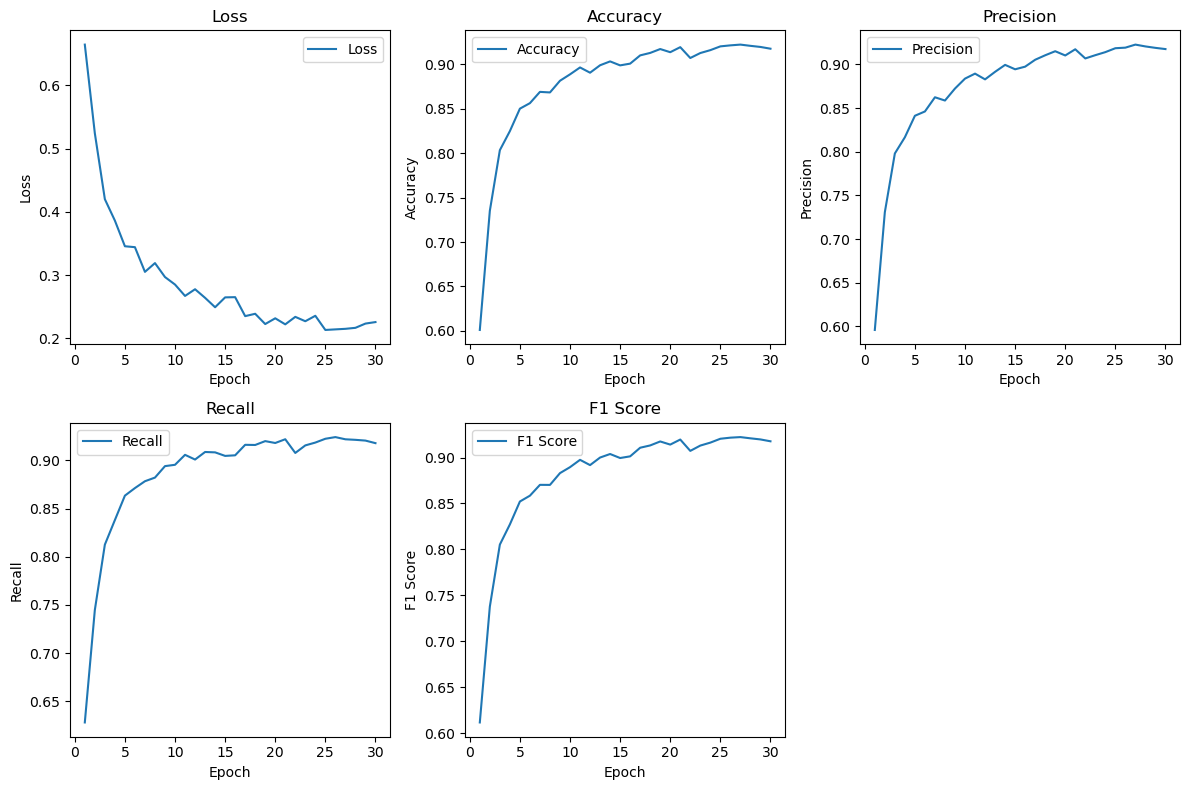

In [133]:
train(metaModel, xTrain, yTrain, numEpochs=50, batchSize=32, learningRate=0.0001, weightDecay=1e-5, earlyStoppingThreshold=5)

During the training phase of the model, a clear performance improvement pattern was observed across epochs. As training progressed over 30 epochs, the model’s performance improved steadily, achieving a peak accuracy of 92.23%, precision of 92.27%, recall of 92.18%, and F1-score of 92.23%.

In [134]:
test(metaModel,xTest, yTest, numIters = 100)

,Accuracy,Precision,Recall,F1
0,0.643750,0.655405,0.606250,0.629870


,Predicted False,Predicted True
Actual False,545,255
Actual True,315,485


### Increasing "numIters"

In [135]:
test(metaModel,xTest, yTest, numIters = 200)

,Accuracy,Precision,Recall,F1
0,0.662707,0.662703,0.662289,0.662496


,Predicted False,Predicted True
Actual False,1061,539
Actual True,540,1059


In [136]:
test(metaModel,xTest, yTest, numIters = 300)

,Accuracy,Precision,Recall,F1
0,0.627892,0.633275,0.606592,0.619646


,Predicted False,Predicted True
Actual False,1558,842
Actual True,943,1454


### Performance Evalution

The  best average performance metrics on test set are obtained when the numIters is equal to 200 (an accuracy of 66.27%, precision of 66.27%, recall of 66.22%, and F1-score of 66.24%). The confusion matrix from the testing results showed 1061 true negatives and 1059 true positives, but also contained 540 false negatives and 539 false positives, indicating problems with both type I and type II errors.

This discrepancy between training and testing performance is indicative of overfitting. Overfitting can be thought of as a model learning too much detail from the training data that it negatively impacts its performance on new data, in a sense memorizing the data used in training.

To reduce overfitting, techniques such as dropout layers, L2 regularization, and early stopping mechanism are added. Data augmentation can normally be considered as well, but it is assumed to be less useful for this task. Data augmentation is a technique to increase the diversity of the training data by applying various transformations such as rotation and scaling. In one-shot learning, since the model is expected to generalize well from a single example, augmenting a single example can lead to more overfitting of the augmented features rather than learning to generalize across naturally occurring variations. Also, since the numbers in MNIST are already centered and scaled to a standard size, common data augmentation techniques may not be useful. In fact, these transformations can potentially change the underlying features of the numbers, for example, rotating a '6' too much can make it look like a '9'.

As a result, while the model demonstrates high efficiency on the training set, its performance on the test set highlights the need for strategies that improve generalization in future model revisions.

### Additional Experiments

#### 1. Experiment: Increasing "dimSpace" of model

In [140]:
metaModel = MetaModel(inputShape, inputShape, dimSpace=128)

Epoch 1/50, Loss: 0.6086, Accuracy: 0.6463, Precision: 0.6409, Recall: 0.6657, F1: 0.6531
Epoch 2/50, Loss: 0.4105, Accuracy: 0.8111, Precision: 0.8073, Recall: 0.8174, F1: 0.8123
Epoch 3/50, Loss: 0.3497, Accuracy: 0.8514, Precision: 0.8463, Recall: 0.8587, F1: 0.8525
Epoch 4/50, Loss: 0.3020, Accuracy: 0.8767, Precision: 0.8707, Recall: 0.8847, F1: 0.8777
Epoch 5/50, Loss: 0.2853, Accuracy: 0.8814, Precision: 0.8762, Recall: 0.8882, F1: 0.8822
Epoch 6/50, Loss: 0.2881, Accuracy: 0.8826, Precision: 0.8780, Recall: 0.8887, F1: 0.8833
Epoch 7/50, Loss: 0.2644, Accuracy: 0.8950, Precision: 0.8921, Recall: 0.8987, F1: 0.8954
Epoch 8/50, Loss: 0.2540, Accuracy: 0.8996, Precision: 0.8933, Recall: 0.9077, F1: 0.9004
Epoch 9/50, Loss: 0.2330, Accuracy: 0.9100, Precision: 0.9082, Recall: 0.9122, F1: 0.9102
Epoch 10/50, Loss: 0.2207, Accuracy: 0.9151, Precision: 0.9130, Recall: 0.9177, F1: 0.9153
Epoch 11/50, Loss: 0.2195, Accuracy: 0.9160, Precision: 0.9132, Recall: 0.9195, F1: 0.9163
Epoch 12

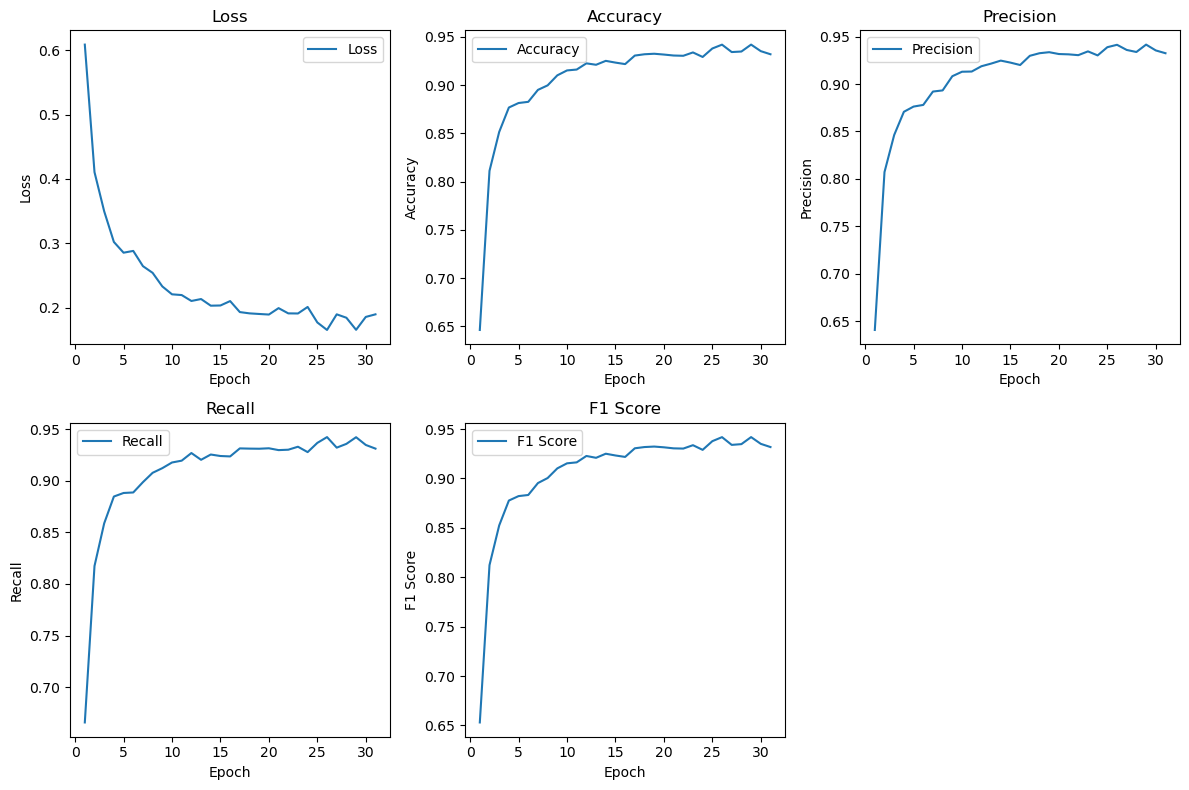

In [141]:
train(metaModel, xTrain, yTrain, numEpochs=50, batchSize=32, learningRate=0.0001, weightDecay=1e-5, earlyStoppingThreshold=5)

In [142]:
test(metaModel,xTest, yTest, numIters = 200)

,Accuracy,Precision,Recall,F1
0,0.659269,0.644684,0.709193,0.675402


,Predicted False,Predicted True
Actual False,975,625
Actual True,465,1134


- Decrease in accuracy: The model is producing more false predictions overall. 
- Decrease in precision: There is a decrease in the accuracy of positive predictions.
- Increase in recall: There is an improvement at identifying all relevant examples and catching more true positives, even if they contain more false positives.
- Increase in F1 score: Since F1 score is equal to the harmonic mean of precision and recall, improvement in this score highlights a better balance between these metrics.

#### 2. Experiment: Decreasing "dimSpace" of model

In [143]:
metaModel = MetaModel(inputShape, inputShape, dimSpace=32)

Epoch 1/50, Loss: 0.7181, Accuracy: 0.5380, Precision: 0.5422, Recall: 0.4883, F1: 0.5139
Epoch 2/50, Loss: 0.5987, Accuracy: 0.6589, Precision: 0.6602, Recall: 0.6549, F1: 0.6576
Epoch 3/50, Loss: 0.5314, Accuracy: 0.7156, Precision: 0.7112, Recall: 0.7260, F1: 0.7185
Epoch 4/50, Loss: 0.4935, Accuracy: 0.7459, Precision: 0.7332, Recall: 0.7731, F1: 0.7526
Epoch 5/50, Loss: 0.4533, Accuracy: 0.7762, Precision: 0.7644, Recall: 0.7985, F1: 0.7811
Epoch 6/50, Loss: 0.4408, Accuracy: 0.7879, Precision: 0.7768, Recall: 0.8080, F1: 0.7921
Epoch 7/50, Loss: 0.4310, Accuracy: 0.7965, Precision: 0.7856, Recall: 0.8157, F1: 0.8003
Epoch 8/50, Loss: 0.4068, Accuracy: 0.8149, Precision: 0.8041, Recall: 0.8328, F1: 0.8182
Epoch 9/50, Loss: 0.3940, Accuracy: 0.8205, Precision: 0.8092, Recall: 0.8388, F1: 0.8238
Epoch 10/50, Loss: 0.3726, Accuracy: 0.8320, Precision: 0.8215, Recall: 0.8483, F1: 0.8347
Epoch 11/50, Loss: 0.3733, Accuracy: 0.8327, Precision: 0.8203, Recall: 0.8521, F1: 0.8359
Epoch 12

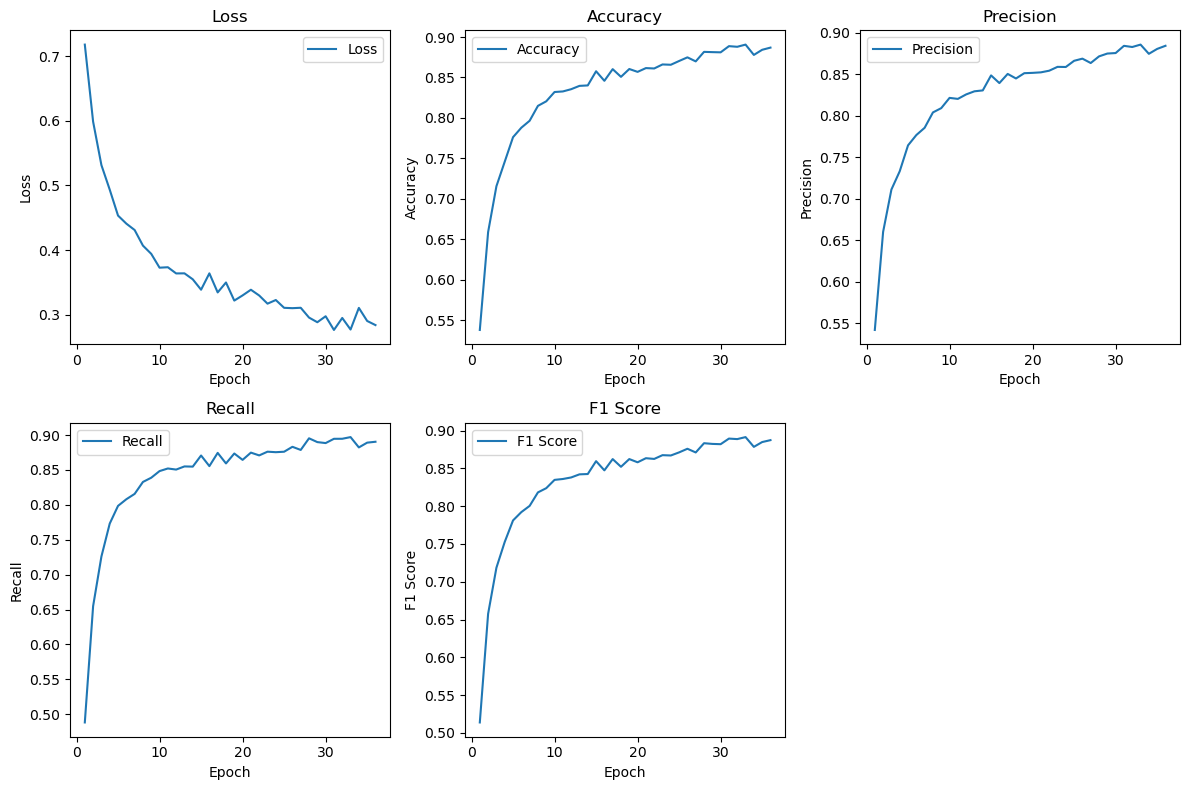

In [144]:
train(metaModel, xTrain, yTrain, numEpochs=50, batchSize=32, learningRate=0.0001, weightDecay=1e-5, earlyStoppingThreshold=5)

In [145]:
test(metaModel,xTest, yTest, numIters = 200)

,Accuracy,Precision,Recall,F1
0,0.610503,0.624559,0.553471,0.586870


,Predicted False,Predicted True
Actual False,1068,532
Actual True,714,885


- Decrease in accuracy: The model is producing more false predictions overall.
- Decrease in precision: There is a decrease in the accuracy of positive predictions.
- Decrease in recall: The model is now less effective at identifying all relevant examples, missing more true positives.
- Decrease in F1 score: A worsening balance between these metrics.

#### 3. Experiment: Decreasing "batchSize" of training

In [146]:
metaModel = MetaModel(inputShape, inputShape, dimSpace=64)

Epoch 1/50, Loss: 0.6144, Accuracy: 0.6452, Precision: 0.6509, Recall: 0.6264, F1: 0.6384
Epoch 2/50, Loss: 0.4385, Accuracy: 0.7948, Precision: 0.7921, Recall: 0.7995, F1: 0.7958
Epoch 3/50, Loss: 0.3606, Accuracy: 0.8465, Precision: 0.8417, Recall: 0.8535, F1: 0.8475
Epoch 4/50, Loss: 0.3305, Accuracy: 0.8617, Precision: 0.8581, Recall: 0.8667, F1: 0.8624
Epoch 5/50, Loss: 0.2944, Accuracy: 0.8800, Precision: 0.8728, Recall: 0.8896, F1: 0.8811
Epoch 6/50, Loss: 0.2843, Accuracy: 0.8865, Precision: 0.8821, Recall: 0.8922, F1: 0.8871
Epoch 7/50, Loss: 0.2838, Accuracy: 0.8889, Precision: 0.8845, Recall: 0.8946, F1: 0.8895
Epoch 8/50, Loss: 0.2748, Accuracy: 0.8946, Precision: 0.8913, Recall: 0.8988, F1: 0.8950
Epoch 9/50, Loss: 0.2569, Accuracy: 0.9014, Precision: 0.8995, Recall: 0.9038, F1: 0.9017
Epoch 10/50, Loss: 0.2513, Accuracy: 0.9027, Precision: 0.9008, Recall: 0.9050, F1: 0.9029
Epoch 11/50, Loss: 0.2474, Accuracy: 0.9045, Precision: 0.9026, Recall: 0.9068, F1: 0.9047
Epoch 12

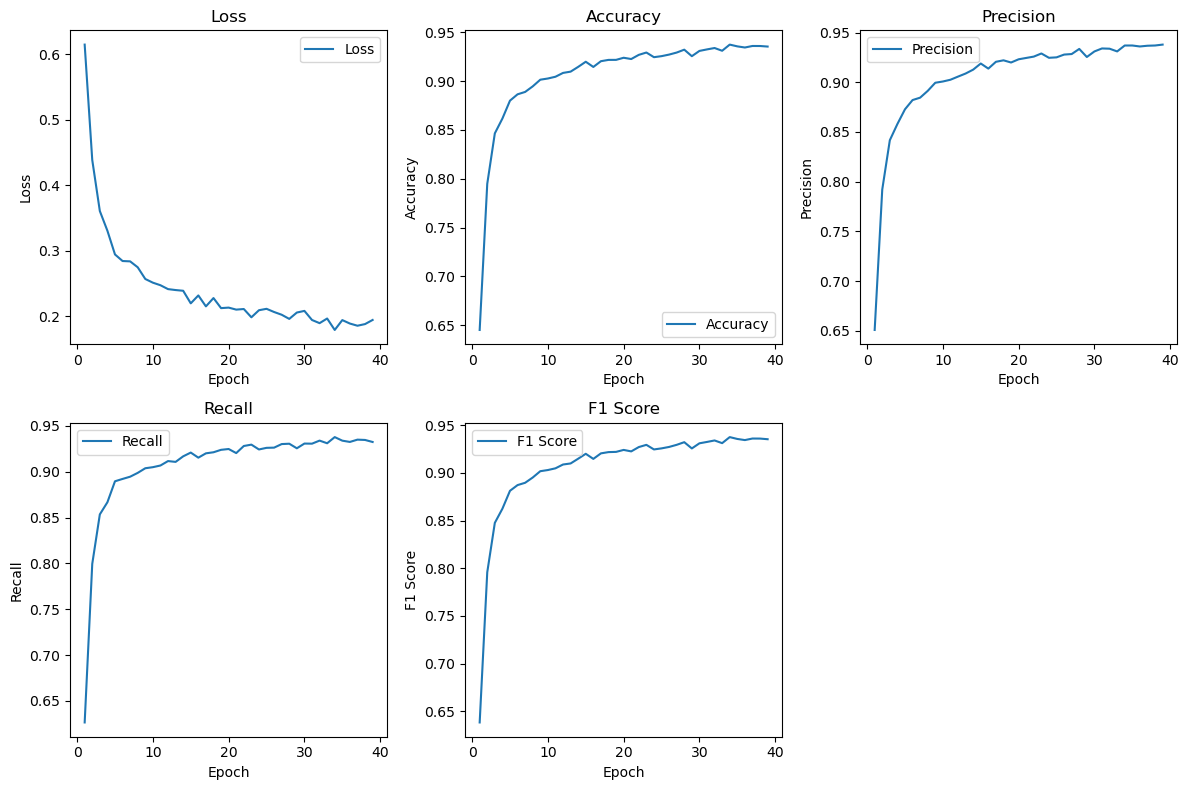

In [ ]:
train(metaModel, xTrain, yTrain, numEpochs=50, batchSize=16, learningRate=0.001, weightDecay=1e-5, earlyStoppingThreshold=5)

In [148]:
test(metaModel,xTest, yTest, numIters = 200)

,Accuracy,Precision,Recall,F1
0,0.641852,0.639851,0.647464,0.643635


,Predicted False,Predicted True
Actual False,1018,582
Actual True,563,1034


- Decrease in accuracy: The model is producing more false predictions overall.
- Decrease in precision: There is a decrease in the accuracy of positive predictions.
- Decrease in recall: The model is now less effective at identifying all relevant examples, missing more true positives.
- Decrease in F1 score: A worsening balance between these metrics.

#### 4. Experiment: Increasing "batchSize" of training

In [149]:
metaModel = MetaModel(inputShape, inputShape, dimSpace=64)

Epoch 1/50, Loss: 0.7076, Accuracy: 0.5385, Precision: 0.5417, Recall: 0.5006, F1: 0.5203
Epoch 2/50, Loss: 0.6221, Accuracy: 0.6406, Precision: 0.6383, Recall: 0.6490, F1: 0.6436
Epoch 3/50, Loss: 0.5533, Accuracy: 0.7070, Precision: 0.7064, Recall: 0.7084, F1: 0.7074
Epoch 4/50, Loss: 0.4826, Accuracy: 0.7650, Precision: 0.7615, Recall: 0.7717, F1: 0.7666
Epoch 5/50, Loss: 0.4470, Accuracy: 0.7867, Precision: 0.7798, Recall: 0.7990, F1: 0.7893
Epoch 6/50, Loss: 0.4031, Accuracy: 0.8186, Precision: 0.8133, Recall: 0.8269, F1: 0.8201
Epoch 7/50, Loss: 0.3839, Accuracy: 0.8263, Precision: 0.8205, Recall: 0.8354, F1: 0.8279
Epoch 8/50, Loss: 0.3637, Accuracy: 0.8393, Precision: 0.8333, Recall: 0.8484, F1: 0.8408
Epoch 9/50, Loss: 0.3639, Accuracy: 0.8451, Precision: 0.8381, Recall: 0.8555, F1: 0.8467
Epoch 10/50, Loss: 0.3360, Accuracy: 0.8597, Precision: 0.8523, Recall: 0.8701, F1: 0.8611
Epoch 11/50, Loss: 0.3265, Accuracy: 0.8652, Precision: 0.8597, Recall: 0.8729, F1: 0.8663
Epoch 12

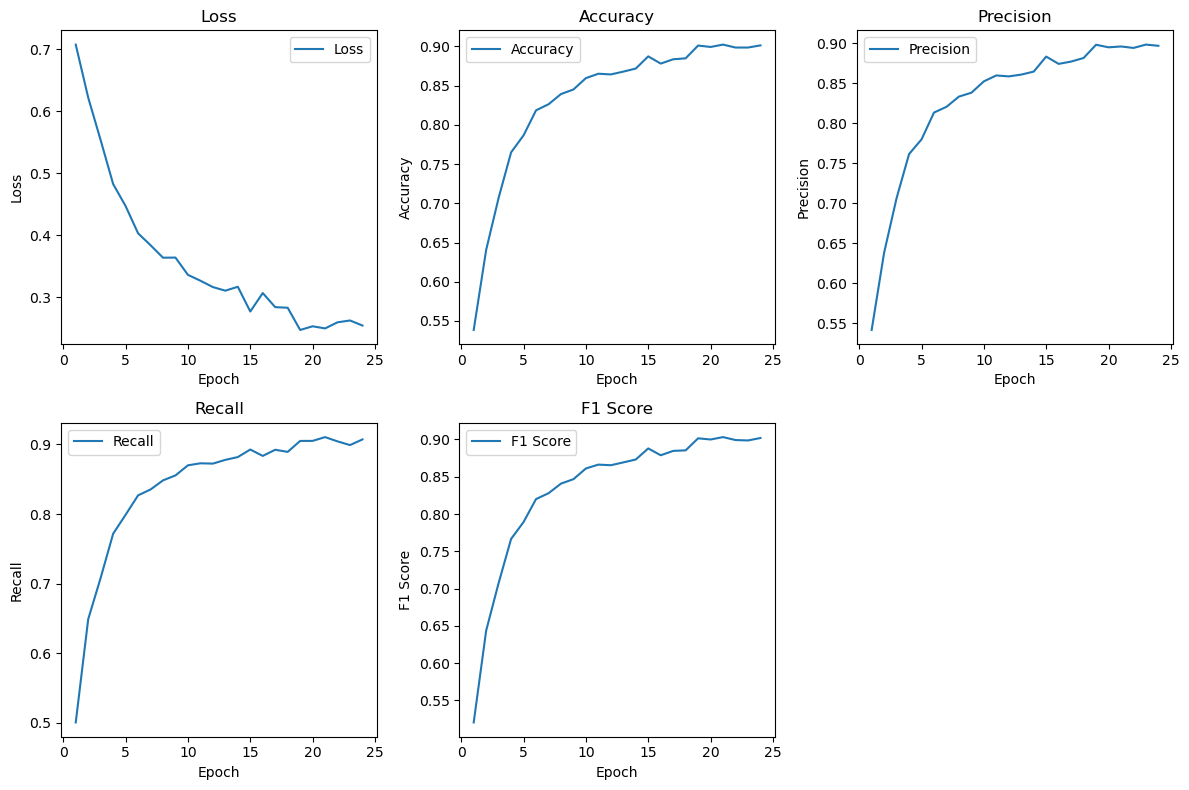

In [150]:
train(metaModel, xTrain, yTrain, numEpochs=50, batchSize=64, learningRate=0.0001, weightDecay=1e-5, earlyStoppingThreshold=5)

In [151]:
test(metaModel,xTest, yTest, numIters = 200)

,Accuracy,Precision,Recall,F1
0,0.625508,0.620132,0.647280,0.633415


,Predicted False,Predicted True
Actual False,966,634
Actual True,564,1035


- Decrease in accuracy: The model is producing more false predictions overall.
- Decrease in precision: There is a decrease in the accuracy of positive predictions.
- Decrease in recall: The model is now less effective at identifying all relevant examples, missing more true positives.
- Decrease in F1 score: A worsening balance between these metrics.

#### 5. Experiment: Increasing "weightDecay" of training

In [152]:
metaModel = MetaModel(inputShape, inputShape, dimSpace=64)

Epoch 1/50, Loss: 0.6802, Accuracy: 0.5761, Precision: 0.5812, Recall: 0.5443, F1: 0.5621
Epoch 2/50, Loss: 0.5442, Accuracy: 0.7129, Precision: 0.7106, Recall: 0.7183, F1: 0.7144
Epoch 3/50, Loss: 0.4466, Accuracy: 0.7864, Precision: 0.7820, Recall: 0.7941, F1: 0.7880
Epoch 4/50, Loss: 0.3891, Accuracy: 0.8239, Precision: 0.8159, Recall: 0.8367, F1: 0.8262
Epoch 5/50, Loss: 0.3759, Accuracy: 0.8301, Precision: 0.8216, Recall: 0.8433, F1: 0.8323
Epoch 6/50, Loss: 0.3369, Accuracy: 0.8555, Precision: 0.8462, Recall: 0.8689, F1: 0.8574
Epoch 7/50, Loss: 0.3102, Accuracy: 0.8722, Precision: 0.8619, Recall: 0.8864, F1: 0.8740
Epoch 8/50, Loss: 0.3062, Accuracy: 0.8715, Precision: 0.8617, Recall: 0.8849, F1: 0.8732
Epoch 9/50, Loss: 0.2901, Accuracy: 0.8842, Precision: 0.8751, Recall: 0.8963, F1: 0.8856
Epoch 10/50, Loss: 0.2905, Accuracy: 0.8829, Precision: 0.8756, Recall: 0.8927, F1: 0.8841
Epoch 11/50, Loss: 0.2619, Accuracy: 0.8956, Precision: 0.8897, Recall: 0.9032, F1: 0.8964
Epoch 12

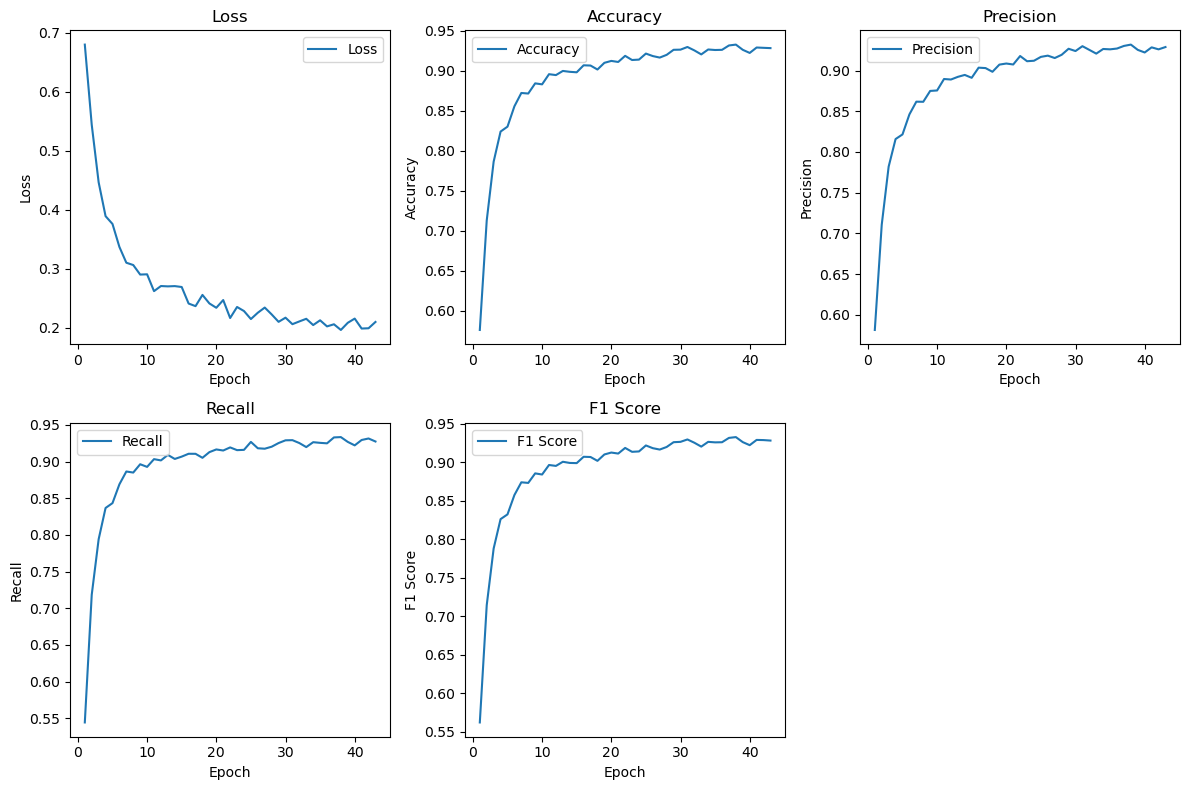

In [153]:
train(metaModel, xTrain, yTrain, numEpochs=50, batchSize=32, learningRate=0.0001, weightDecay=3e-5, earlyStoppingThreshold=5)

In [154]:
test(metaModel,xTest, yTest, numIters = 200)

,Accuracy,Precision,Recall,F1
0,0.658018,0.678193,0.601001,0.637268


,Predicted False,Predicted True
Actual False,1144,456
Actual True,638,961


- Decrease in accuracy: The model is producing more false predictions overall.
- Increase in precision: There is an increase in the accuracy of positive predictions, meaning the model is more correct when it predicts a positive class.
- Decrease in recall: The model is now less effective at identifying all relevant examples, missing more true positives.
- Decrease in F1 score: A worsening balance between these metrics.

#### 6. Experiment: Increasing "learningRate" of training

In [155]:
metaModel = MetaModel(inputShape, inputShape, dimSpace=64)

Epoch 1/50, Loss: 49.9336, Accuracy: 0.5000, Precision: 0.5000, Recall: 0.9884, F1: 0.6641
Epoch 2/50, Loss: 50.0000, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Epoch 3/50, Loss: 50.2793, Accuracy: 0.4969, Precision: 0.4980, Recall: 0.7731, F1: 0.6058
Epoch 4/50, Loss: 49.9418, Accuracy: 0.5004, Precision: 0.5002, Recall: 0.9253, F1: 0.6494
Epoch 5/50, Loss: 49.9521, Accuracy: 0.4999, Precision: 0.4999, Recall: 0.9714, F1: 0.6601
Epoch 6/50, Loss: 50.0756, Accuracy: 0.4992, Precision: 0.4996, Recall: 0.9632, F1: 0.6579
Early stopping triggered.


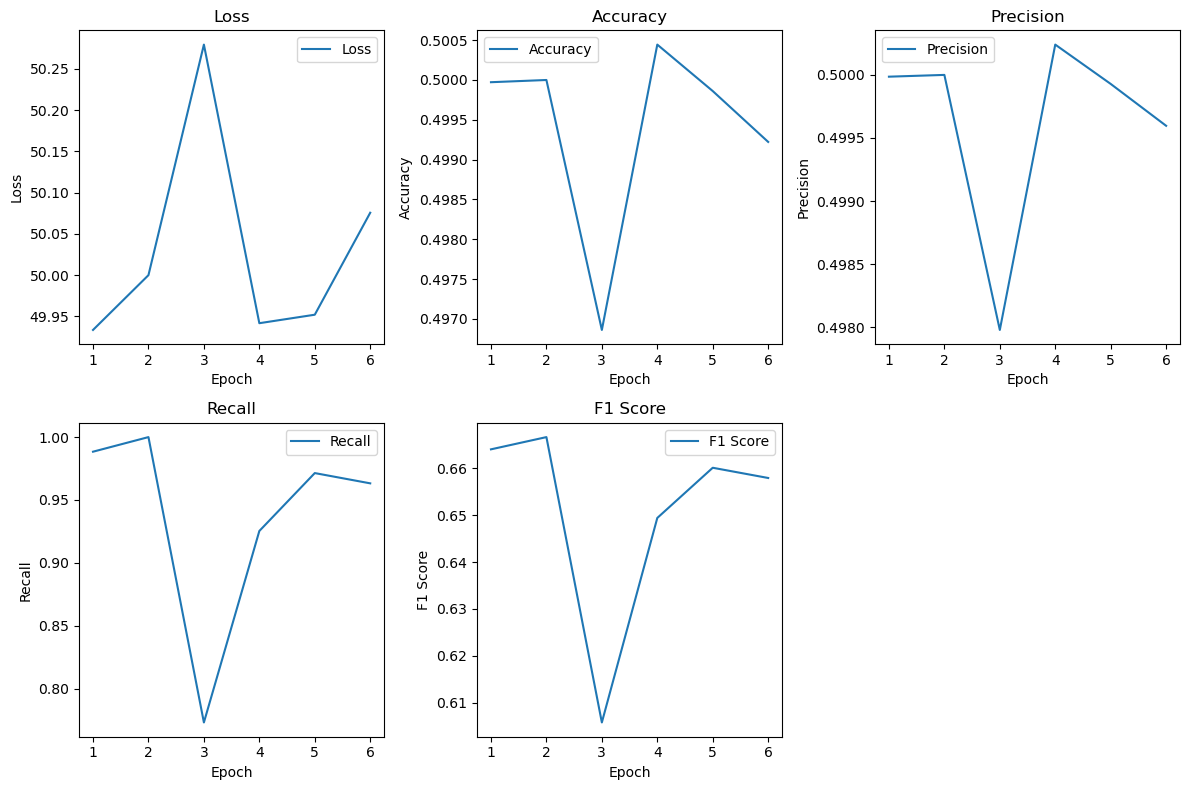

In [156]:
train(metaModel, xTrain, yTrain, numEpochs=50, batchSize=32, learningRate=0.1, weightDecay=3e-5, earlyStoppingThreshold=5)

In [157]:
test(metaModel,xTest, yTest, numIters = 200)

,Accuracy,Precision,Recall,F1
0,0.500000,0.500000,1.000000,0.666667


,Predicted False,Predicted True
Actual False,0,1600
Actual True,0,1600


Given the provided metrics and the confusion matrix, it is clear that the model predicts every instance as true regardless of their label. This results can be seen in a situation where the dataset consists of an equal split between true and false classes and model predicts everything as true.

The model has an accuracy of 50%, which reflects that the model correctly identifies all the true instances while misclassifying all the false instances. This also proves that the number of correct predictions is equal to the number of false predictions.

A precision of 50% suggests that only half of the positive predictions made by the model are correct. A high recall of 100% indicates that the model is effective at detecting true instances as it captures every true instance in the dataset, but this metric is misleading as the model assumes everything is true.

This example shows the importance of paying attention to the values ​​of all metrics when evaluating the model.

## References

1. Less Than One-Shot Learning for Dummies. Retrieved from [Medium](https://medium.com/swlh/less-than-one-shot-learning-for-dummies-49dc2f01a679).
2. Meta-Learning - IBM. Retrieved from [IBM](https://www.ibm.com/think/topics/meta-learning).
3. Siamese Neural Networks for One-shot Image Recognition. Retrieved from [University of Toronto](https://www.cs.toronto.edu/~rsalakhu/papers/oneshot1.pdf).
4. Few-Shot One-Class Classification via Meta-Learning. Retrieved from [AAAI](https://cdn.aaai.org/ojs/16913/16913-13-20407-1-2-20210518.pdf).
5. Understanding Siamese Network with example and codes. Retrieved from [Medium](https://medium.com/data-science-in-your-pocket/understanding-siamese-network-with-example-and-codes-e7518fe02612.)
